# Example 0
## Anomaly detection in artificial data with linear neuron
In this example we demonstrate the capabilities of Learning Entropy on anomaly detection for artificial signal monitored with linear neuron. 

In this example we first generate 3 sinus signals with 3 different frequencies. To the generated signal we then plant an anomaly (frequency change, amplitude change, phase shift)

In [1]:
# Import required libs
import matplotlib.pyplot as plt
import numpy as np

%cd ..
# Pythonic AISLE

# JAX accelerated AISLE

%matplotlib widget

c:\GitRepos\JAX_accelerated_LE


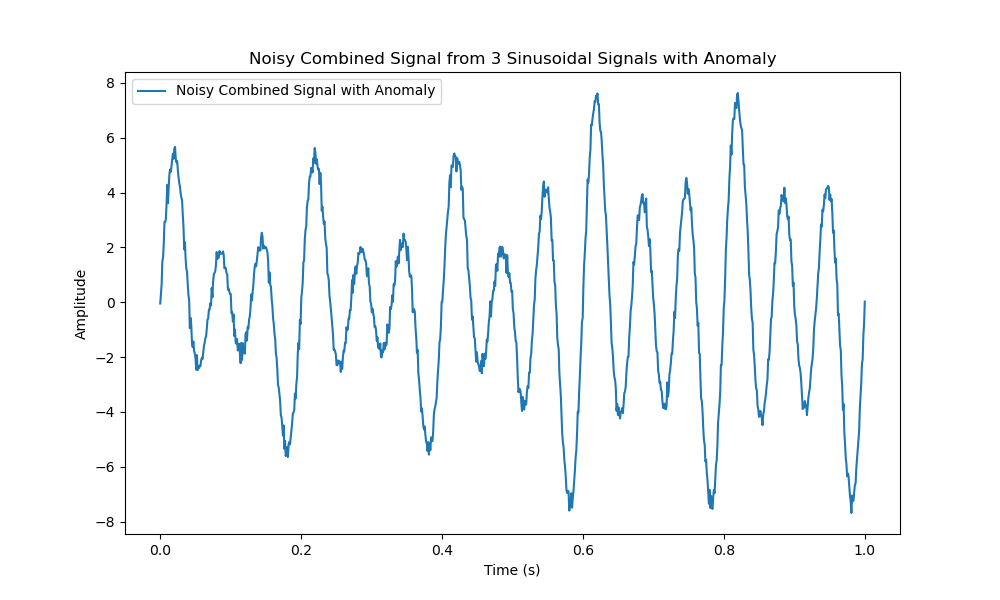

In [8]:
# Constants
frequencies = [5, 10, 15]  # Frequencies in Hz for each signal
amplitudes = [1, 2, 3]  # Amplitudes for each signal
phases = [0, 0, 0]  # Phases in radians for each signal
N = 500  # Anomaly start position
noise_level = 0.2  # Noise level

# Anomaly parameters
anomaly_type = "amplitude"  # Options: 'amplitude', 'frequency', 'phase'
anomaly_value = 5  # New value for the chosen parameter
corrupted_signal_index = 2  # Index for which signal to corrupt: 0 for signal1, 1 for signal2, 2 for signal3

# Time domain
t = np.linspace(0, 1, 1000)  # 1 second, 1000 samples

# Generate signals
signals = [amplitudes[i] * np.sin(2 * np.pi * frequencies[i] * t + phases[i]) for i in range(3)]

# Introduce anomaly in the chosen signal from Nth position
if anomaly_type == "amplitude":
    signals[corrupted_signal_index][N:] = anomaly_value * \
        np.sin(2 * np.pi * frequencies[corrupted_signal_index] * t[N:] + phases[corrupted_signal_index])
elif anomaly_type == "frequency":
    signals[corrupted_signal_index][N:] = amplitudes[corrupted_signal_index] * \
        np.sin(2 * np.pi * anomaly_value * t[N:] + phases[corrupted_signal_index])
elif anomaly_type == "phase":
    signals[corrupted_signal_index][N:] = amplitudes[corrupted_signal_index] * \
        np.sin(2 * np.pi * frequencies[corrupted_signal_index] * t[N:] + anomaly_value)

# Combine signals
combined_signal = np.sum(signals, axis=0)

# Generate and add noise
noise = np.random.normal(0, noise_level, combined_signal.shape)
noisy_combined_signal = combined_signal + noise

# Plot the combined signal with noise
plt.figure(figsize=(10, 6))
plt.plot(t, noisy_combined_signal, label="Noisy Combined Signal with Anomaly")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Noisy Combined Signal from 3 Sinusoidal Signals with Anomaly")
plt.legend()
plt.show()